In [1]:
import os
import shutil
import flopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ! Custom modules
from utils import pht3d_fsp
from utils.tools import calculate_MAS_sums, clear_directory
from utils.pht3d_utils import copy_pht3d_datab, run_pht3d_program

clear_directory()

In [2]:
data_folder = 'case2'
model_name = 'case2_modflow'
model_ws = './models_folder/' + data_folder

Lx = 0.5
Ly = 1.0
Lz = 1.0

nrow = 1
ncol = 50
nlay = 1

delr = [0.01] * ncol 
delc = [1.0]
top = 1.0
botm = 0.0

hk = 1.0

nper = 1
perlen = np.array([1.24305,])
nstp = [210,]
steady = [True,]

model = flopy.modflow.Modflow(modelname=model_name, model_ws=model_ws, exe_name='./bin/mf2005')
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, 
                              delr=delr, delc=delc, top=top, botm=botm,
                              nper=nper, perlen=perlen, nstp=nstp, steady=steady)

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[0, 0, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=strt)

lpf = flopy.modflow.ModflowLpf(model, hk=hk, laytyp=1, ipakcb=53)

chd_data = {0: [[0, 0, ncol-1, 1.0, 1.0],]}
chd = flopy.modflow.ModflowChd(model, stress_period_data=chd_data)

wel_data = {0: [[0, 0, 0, 0.259061],]}
wel = flopy.modflow.ModflowWel(model, stress_period_data=wel_data)

lmt = flopy.modflow.ModflowLmt(model, output_file_name='mt3d_link.ftl')

stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", "save budget", "print head", "print budget",]
oc = flopy.modflow.ModflowOc(model, stress_period_data=stress_period_data, compact=True)
pcg = flopy.modflow.ModflowPcg(model=model)

model.write_input()
success, mfoutput = model.run_model(silent=True, pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

R2 score:  1.0


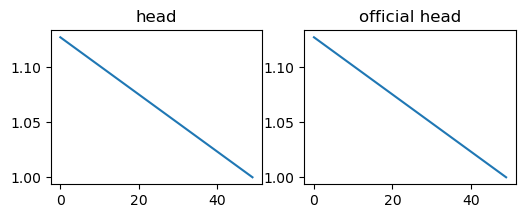

In [3]:
head = flopy.utils.binaryfile.HeadFile(model_ws+'/'+model_name+".hds").get_alldata()
head_official = flopy.utils.binaryfile.HeadFile("./official_examples/ex02_pht3d/mf2k/heads.dat").get_alldata()

plt.figure(figsize=(6,2))
plt.subplot(121)
plt.plot(head[-1, 0, 0])
plt.title("head")
plt.subplot(122)
plt.plot(head_official[-1, 0, 0])
plt.title("official head")

print("R2 score: ", r2_score(np.ravel(head_official), np.ravel(head)))

In [4]:
## Create PHT3D Reactive Transport Model, supported by PHT3D-FSP
## Define "spec", calling PHT3D-FSP (adopt function variables as needed)
spec = pht3d_fsp.create(
    xlsx_path="./", 
    xlsx_name=f"./data/{data_folder}/pht3d_species.xlsx",
    nlay=nlay, 
    nrow=nrow,
    ncol=ncol,
    ph_os=2,
    ph_temp=25,
    ph_asbin=1,
    ph_eps_aqu=0,
    ph_ph=0,
    # ph_print=0,
    ph_cb_offset=0,
    # ph_surf_calc_type="-diffuse_layer",
    write_ph="yes"
)
# Move the pht3d_ph.dat file into the models_folder
source = 'pht3d_ph.dat'
destination = os.path.join(model_ws, 'pht3d_ph.dat')
shutil.move(source, destination)

'./models_folder/case2\\pht3d_ph.dat'

In [5]:
# Define SSM and RCH data (for the SSM package) for each stress period
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict() # ... to check the key words
# print(itype)
# {'CHD': 1, 'BAS6': 1, 'PBC': 1, 'WEL': 2, 'DRN': 3, 'RIV': 4, 'GHB': 5, 'MAS': 15, 'CC': -1}

wel_spec={}

for i in range(1):
    for key in spec.keys():
        wel_spec[key]=spec[key][0,0,0]

    wel_spec['c4'] = 0.0
    wel_spec['ca'] = 0.0
    wel_spec['mg'] = 0.001
    wel_spec['cl'] = 0.002
    wel_spec['ph'] = 7.0
    wel_spec['pe'] = 4.0
    wel_spec['calcite'] = 0
    wel_spec['dolomite'] = 0
    
    ssm_per=[0,0,0,0.0,itype['WEL']]
    for key in spec.keys():
        ssm_per.append(wel_spec[key])
    
    ssm_data[i] = ssm_per
    
ssm_data

{0: [0, 0, 0, 0.0, 2, 0.0, 0.0, 0.001, 0.002, 7.0, 4.0, 0, 0]}

In [18]:
model_name = 'case2_mt3dms'
icbund = np.abs(ibound)

mt = flopy.mt3d.Mt3dms(model_name, model_ws=model_ws, exe_name='./bin/mt3dms',
                      ftlfilename='mt3d_link.ftl',modflowmodel=model, namefile_ext='nam_pht3d')

prsity = 0.32

exec(f'btn = flopy.mt3d.Mt3dBtn(mt, \
                                nper=nper, perlen=perlen, nstp=nstp,\
                                nlay=nlay, ncol=ncol, nrow=nrow, \
                                laycon=[1], prsity=prsity, icbund=icbund, nprs=0, mxstrn=50000, tsmult=1, timprs=[0, 0.12, 0.24305], \
    ncomp={pht3d_fsp.create.ncomp}, mcomp={pht3d_fsp.create.mcomp}, {pht3d_fsp.create.sconc_btn})') # call BTN package in this way to invoke PHT3D-FSP variables

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1, percel=0.75, mxpart=5000, nadvfd=0)
dsp = flopy.mt3d.Mt3dDsp(mt, al=0.0067, trpt=0.1, trpv=0.1, multiDiff=True, dmcoef=0.0,)
gcg = flopy.mt3d.Mt3dGcg(mt, isolve=1, cclose=1.e-8)
exec(f'ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data, mxss=1000)')
mt.write_input()

DSP: setting dmcoef for component 2 to zero, kwarg name dmcoef2
DSP: setting dmcoef for component 3 to zero, kwarg name dmcoef3
DSP: setting dmcoef for component 4 to zero, kwarg name dmcoef4


In [19]:
# Manually add the PHC reaction package to the nam file and push out as pht3d.nam
s='PHC               39  pht3d_ph.dat\n'
namfiletxt=open(model_ws + '/'+ mt.namefile, 'r').read()
pht3d_nam = namfiletxt+s
file = open(model_ws + '/pht3d.nam','w')
file.write(pht3d_nam)
file.close()

In [20]:
copy_pht3d_datab(source_folder=data_folder)

run_pht3d_program(work_dir=data_folder)

The file pht3d_datab.dat has been copied to the model folder.
 PHT3D - [Version 2.10]
 Reactive Multicomponent Transport based on MT3DMS and PHREEQC-2.
 Developed by Henning Prommer / Vincent Post

 Using NAME File: pht3d.nam                                         

 STRESS PERIOD NO.    1
 Calling PHREEQC to equilibrate SSM solutions

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO   0.59193E-02

 Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
 Transport Step:    2   Step Size:  5.9193E-03 Total Elapsed Time:  5.91929E-03
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2992      [K,I,J]    1    1   50
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5291E-01  [K,I,J]    1    1   49
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1057E-01  [K,I,J]    1    1   48
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2151E-02  [K,I,J]    1    1   47
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4382E-03  [K,I,J]    1    1   46
 Outer Iter.  1  Inner Iter.  6:  Max

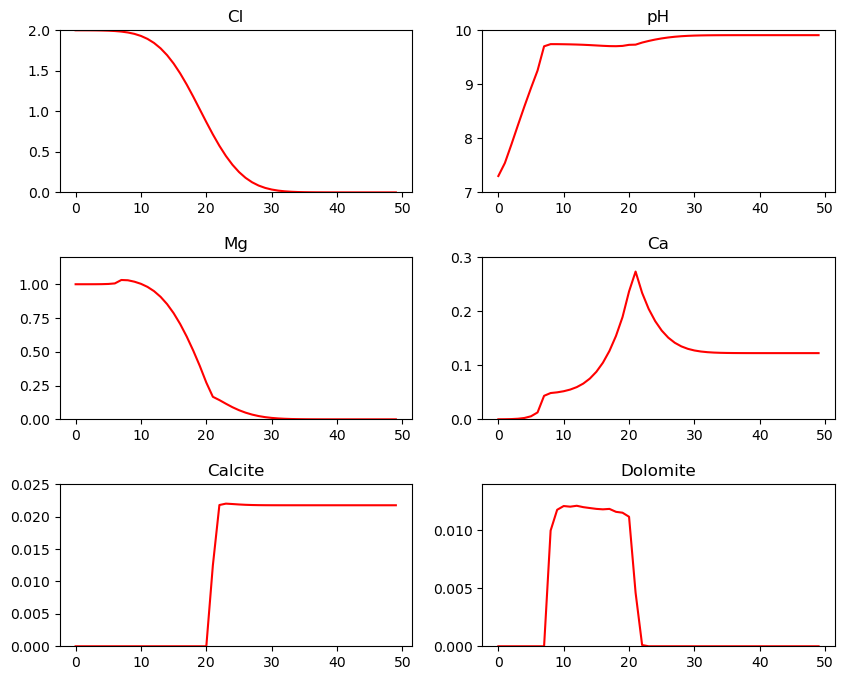

In [24]:
results_ca = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D002.UCN').get_alldata()[2, 0, 0]*1000
results_mg = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D003.UCN').get_alldata()[2, 0,0]*1000
results_cl = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D004.UCN').get_alldata()[2, 0,0]*1000
results_ph = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D005.UCN').get_alldata()[2, 0,0]
results_calcite = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D007.UCN').get_alldata()[2, 0,0]*1000
results_dolomite = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D008.UCN').get_alldata()[2, 0,0]*1000

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(3, 2, 1)
ax.plot(results_cl, color="red")
ax.set_title("Cl")
ax.set_ylim(0, 2.0)
ax = fig.add_subplot(3, 2, 2)
ax.plot(results_ph, color="red")
ax.set_title("pH")
ax.set_ylim(7.0, 10.0)
ax = fig.add_subplot(3, 2, 3)
ax.plot(results_mg, color="red")
ax.set_title("Mg")
ax.set_ylim(0.0, 1.2)
ax = fig.add_subplot(3, 2, 4)
ax.plot(results_ca, color="red")
ax.set_title("Ca")
ax.set_ylim(0.0, 0.30)
ax = fig.add_subplot(3, 2, 5)
ax.plot(results_calcite / 1.8, color="red")
ax.set_title("Calcite")
ax.set_ylim(0.0, 0.025)
ax = fig.add_subplot(3, 2, 6)
ax.plot(results_dolomite / 1.8, color="red")
ax.set_title("Dolomite")
ax.set_ylim(0.0, 0.014)

plt.subplots_adjust(top=None, bottom=None, left=None, right=None, hspace=0.4, wspace=None)